Strategy Performance on Test Set
--------

Here we test our strategy on our INTC test set data using our most promising RNN predictions for given latencies

In [1]:
#Package imports
import pandas as pd
import numpy as np
import os
import math
import sys
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
sys.path.insert(0, os.path.join(os.getcwd(), 'code'))

import OrderBook as ob
import OrderUtil as ou
import TradingStrategySimulator as tss
import FillProbabilitySimulator as fps
path = os.path.join(os.getcwd(), 'data')

In [2]:
#load in orderbook data
book = ob.OrderBook(message_filename='INTC_message.csv', orderbook_filename='INTC_OrderBook.csv')

In [3]:
#load in RNN predictions
y_test= pd.read_csv(os.path.join(path, 'pred_test_intc_up&down_nolesssprd.csv'))
y_times_test = pd.read_csv(os.path.join(path, 'y_test_time_intc_up&down_nolesssprd.csv'))
y_test = pd.DataFrame(y_test.values, index=y_times_test)
y_test['timestamp'] = y_times_test.values
y_test.drop_duplicates(subset='timestamp', keep='last', inplace=True)
y_test.set_index('timestamp', inplace=True)
strat = {1: ([1, 2, 3, 4, 5], [1, 2, 3, 4, 5]),
         -1 : ([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])}
midprice_df = book.get_midprice_data(numupdates=1, t_start=54160, t_end=57590, tick_size=100, next_move=True)
midprice_df.dropna(inplace=True)
y_test = y_test.reindex_axis(midprice_df.index, method='bfill')

#set our predictions to those outputted by our RNN
midprice_df['y_predict'] = y_test[2]

Performance with Different Latencies
--------
Latency is applied for both orderbook refreshing and placing/cancelling orders

We run our strategy for the following latencies:
- Fastest possible latency, every orderbook update (~1 nanosecond)
- 1 microsecond
- 10 microseconds
- 100 microseconds
- 1 millisecond
- 10 milliseconds
- 1 second

In [4]:
performance_df = pd.DataFrame(index=range(54160, 57590),
                              columns=['~1_nanosecond', '1_microsecond',
                                       '10_microseconds', '100_microseconds',
                                       '1_millisecond', '10_milliseconds', '1_second'])

count = 0
for latency in [(0, 0), (1e-6, 1e-6), (1e-5, 1e-5), (1e-4, 1e-4), (1e-3, 1e-3), (1e-2, 1e-2), (1, 1)]:
    print("\nRunning Strategy using latency of " + str(latency[0]) + " seconds:\n")
    backtester = tss.TradingStrategyBacktester(book=book, midprice_df=midprice_df, strategy=strat,                                     
                                               max_exposure_dict={1:1, -1:1}, latency=latency,
                                               tick_size=100)
    backtester.run_strategy()
    pnls = backtester.get_pnl_series()
    cum_pnls = pnls.cumsum()
    cum_pnls = cum_pnls.reindex_axis(performance_df.index, method='ffill')
    performance_df.iloc[:, count] = cum_pnls
    count += 1
    
print("done")


Running Strategy using latency of 0 seconds:

Current time:        54160.40692089
Current pnl: 0.0
Current time:        54752.692022862
Current pnl: 400.0
Current time:        55135.513492499995
Current pnl: 1000.0
Current time:        55435.104089687
Current pnl: 1200.0
Current time:        55840.150144702005
Current pnl: 1300.0
Current time:        56191.925994372
Current pnl: 1500.0
Current time:        56491.850371773
Current pnl: 1700.0
Current time:        56850.543401762996
Current pnl: 2000.0
Current time:        57104.211982499
Current pnl: 2200.0
Current time:        57281.17088993901
Current pnl: 2500.0
Current time:        57517.091888796
Current pnl: 2750.0

Running Strategy using latency of 1e-06 seconds:

Current time:        54161.596079999996
Current pnl: 0.0
Current time:        54753.377716999996
Current pnl: 0.0
Current time:        55136.627035
Current pnl: 500.0
Current time:        55438.733736999995
Current pnl: 500.0
Current time:        55851.083354999995
Cur

Plot of PNLs vs given Latency Below
--------

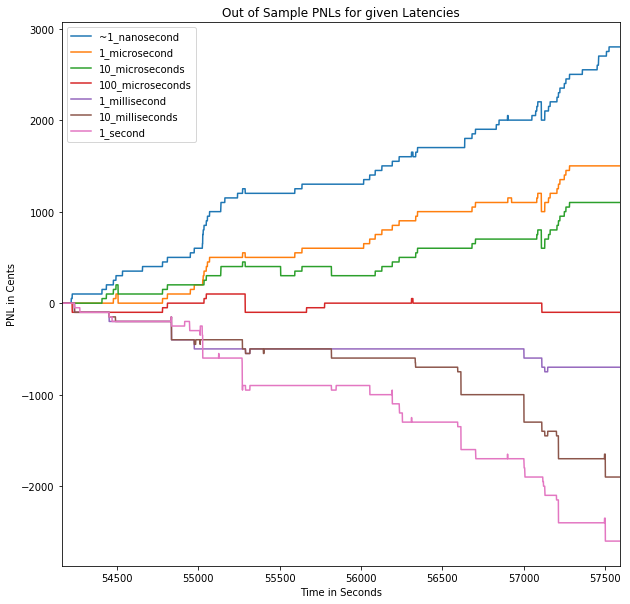

In [5]:
performance_df.plot()
plt.title("Out of Sample PNLs for given Latencies")
plt.xlabel("Time in Seconds")
plt.ylabel("PNL in Cents")
plt.legend()
plt.show()